In [2]:
import pandas as pd
import numpy as np

from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem import PandasTools
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import AllChem
from rdkit.Chem import rdFingerprintGenerator
from rdkit import DataStructs
from rdkit.Chem import MACCSkeys
from rdkit.Chem.Fingerprints import FingerprintMols
import matplotlib.pyplot as plt

from descriptastorus.descriptors.DescriptorGenerator import MakeGenerator
#https://github.com/bp-kelley/descriptastorus


# Input both test/training dataset 

In [3]:
full_copy = pd.read_csv('../../../project1_data/Series4_full.csv', index_col = 'ID')
# full_copy.head()
PandasTools.AddMoleculeColumnToFrame(full_copy,smilesCol='SMILES')
# full_copy.head()

# Generating descriptors using RDKit

In [4]:
# RDKit
generator = MakeGenerator(("RDKit2D",))

full_copy_rdkit2d = [generator.process(x)[1:] for x in full_copy['SMILES']]

In [5]:
rdkit2d_name = []
for name, numpy_type in generator.GetColumns():
    rdkit2d_name.append(name)
    
full_copy_rdkit2d_df = pd.DataFrame(full_copy_rdkit2d, index = full_copy.index, columns=rdkit2d_name[1:])

In [6]:
# full_copy_rdkit2d_df.head()

# MACCS keys 

In [7]:
# full_copy_MAACS = [MACCSkeys.GenMACCSKeys(x) for x in full_copy['ROMol']]
# full_copy_MAACS_list = [list(l) for l in full_copy_MAACS]
# maccs_name = [f'Bit_{i}' for i in range(167)]
# full_copy_MAACS_df = pd.DataFrame(full_copy_MAACS_list, index = full_copy.index, columns=maccs_name)
# full_copy_MAACS_df

In [8]:
# Mergind MACCS and RDKit descriptors

# full_copy_rdkit2d_df = pd.merge(full_copy_MAACS_df,full_copy_rdkit2d_df,left_on='ID',right_on='ID')
# full_copy_rdkit2d_df.shape

In [9]:
full_copy_rdkit2d_df.to_csv('../../../project1_data/full_copy_rdkit2d_df.csv')

In [10]:
TrainTest=full_copy.drop(full_copy[full_copy.type == 'validation'].index)
TrainTest.drop(TrainTest[TrainTest.type == 'excluded'].index, inplace=True)
TrainTest.drop(TrainTest[TrainTest.type == 'excluded_subset'].index, inplace=True)

# full_copy.shape
validation=full_copy.drop(full_copy[full_copy.type == 'TestTrain'].index)
validation.drop(validation[validation.type == 'excluded'].index, inplace=True)
validation.drop(validation[validation.type == 'excluded_subset'].index, inplace=True)

excluded=full_copy.drop(full_copy[full_copy.type == 'TestTrain'].index)
excluded.drop(excluded[excluded.type == 'validation'].index, inplace=True)
excluded.drop(excluded[excluded.type == 'excluded'].index, inplace=True)


# excluded


In [11]:
allMerged = pd.merge(TrainTest,full_copy_rdkit2d_df,left_on='ID',right_on='ID')
allMerged_validation = pd.merge(validation,full_copy_rdkit2d_df,left_on='ID',right_on='ID')
allMerged_excluded = pd.merge(excluded,full_copy_rdkit2d_df,left_on='ID',right_on='ID')
# allMerged_excluded.tail()

In [12]:
allMerged.drop(['type', 'Cluster member', 'Cluster type', 'ROMol', 'MCS Cluster'], axis=1, inplace=True)
allMerged_validation.drop(['type', 'Cluster member', 'Cluster type', 'ROMol', 'MCS Cluster'], axis=1, inplace=True)
allMerged_excluded.drop(['type', 'Cluster member', 'Cluster type', 'ROMol', 'MCS Cluster'], axis=1, inplace=True)
allMerged.dropna(inplace=True)

allMerged.drop(['desired'], axis=1, inplace=True)
allMerged_validation.drop(['desired'], axis=1, inplace=True)
allMerged_excluded.drop(['desired'], axis=1, inplace=True)

# allMerged.drop(allMerged[allMerged.clearance > 49.9].index, inplace=True)
# allMerged.drop(allMerged[allMerged.desired < 4.6].index, inplace=True)
# allMerged.drop(allMerged[allMerged.clearance < 0.51].index, inplace=True)
# allMerged[allMerged['clearance'] > 49.9 ]


In [14]:
# allMerged_excluded.head()

# Random forest 

In [16]:
X = allMerged.iloc[:, 2:,].values #descreptors
y = allMerged.iloc[:, 1].values #desired property
# y

In [17]:
# print(X.shape)
# print(y)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=4)
print(X_train.shape)
# print(X_test.shape)
# print(y_train.shape)
# print(y_test.shape)

(156, 200)


In [18]:
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)
X_train.shape

(156, 200)

Mean Absolute Error: 6.629468786845235
Mean Squared Error: 106.85011163869426
Root Mean Squared Error: 10.336832766311655


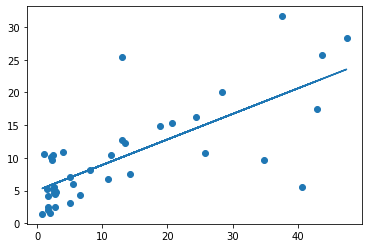

In [21]:
from sklearn.ensemble import RandomForestRegressor

regressor = RandomForestRegressor(n_estimators=500, random_state=4)
regressor.fit(X_train, y_train)
y_pred = regressor.predict(X_test)

from sklearn import metrics

print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

from sklearn.metrics import r2_score
plt.scatter(y_test, y_pred)
m, b = np.polyfit(y_test, y_pred, 1)
plt.plot(y_test, m*y_test + b)
# plt.axes.set_title()
# plt.title('R2: ' + str(r2_score(y_test, y_pred)))

# Validation datasets

In [22]:
X_valid = allMerged_validation.iloc[:, 2:,].values #descreptors
y_valid = allMerged_validation.iloc[:, 1].values #desirable data

# allMerged_excluded.dropna(inplace=True)
# X_valid = allMerged_excluded.iloc[:, 2:,].values #descreptors
# y_valid = allMerged_excluded.iloc[:, 1].values #desirable data

X_valid.shape
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_valid_norm = sc.fit_transform(X_valid)
X_valid_norm.shape
# allMerged_excluded.dropna(inplace=True)
# allMerged_excluded

(14, 200)

Mean Absolute Error: 5.31315929427438
Mean Squared Error: 46.13393192085986
Root Mean Squared Error: 6.792196398872743
XXXXXXXXXXXXXXXXXXXXX


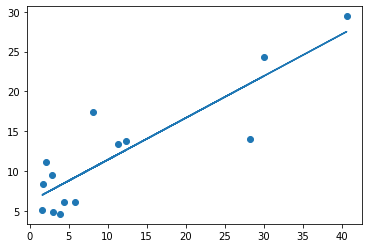

In [23]:
Y_valid_pred = regressor.predict(X_valid_norm)
# print(X_valid_norm)
print('Mean Absolute Error:', metrics.mean_absolute_error(y_valid, Y_valid_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y_valid, Y_valid_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_valid, Y_valid_pred)))
print('XXXXXXXXXXXXXXXXXXXXX')
plt.scatter(y_valid, Y_valid_pred)
m, b = np.polyfit(y_valid, Y_valid_pred, 1)
plt.plot(y_valid, m*y_valid + b)
# plt.title('R2: ' + str(r2_score(y_valid, Y_valid_pred)))